In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 9.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import sklearn
from sklearn.preprocessing import StandardScaler

import torch
import nltk
from tqdm import tqdm
import copy

from torch.utils.data import Dataset

import torch.nn as nn
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import time
from torchmetrics import Accuracy
from torchmetrics import MeanSquaredError

# model assessment
from sklearn.metrics import r2_score, accuracy_score, mean_squared_error
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device being used:", device)

Device being used: cpu


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/Dataset_hyperEarlyStop/'

/content/drive/MyDrive/Dataset_hyperEarlyStop


## DataLoader

In [102]:
class EarlyStop(Dataset):

    def __init__(self, path, dataset_type='train', E=150, M=150):
        self.train_loss_df = pd.read_csv(f'{path}/preprocessed_dataset/train_loss_{dataset_type}.csv', index_col=0)
        self.eval_loss_df = pd.read_csv(f'{path}/preprocessed_dataset/eval_loss_{dataset_type}.csv', index_col=0) 
        self.eval_acc_df = pd.read_csv(f'{path}/preprocessed_dataset/eval_acc_{dataset_type}.csv', index_col=0)
        self.data = []
        self.E = E
        self.M = M
        for i in range(len(self.train_loss_df)):
            train_loss = np.array(self.train_loss_df.iloc[i])[:E]
            eval_loss = np.array(self.eval_loss_df.iloc[i])[4:E+4]
            eval_acc = np.array(self.eval_acc_df.iloc[i])[4:E+4]
            stacked_data = np.vstack((train_loss, eval_loss, eval_acc)).T
            self.data.append(stacked_data)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        X_sample = self.data[idx]
        y_sample = np.array(self.eval_acc_df.iloc[idx])[(self.M)-1+4]
        return (X_sample, y_sample)

In [103]:
path = '/content/drive/MyDrive/Dataset_hyperEarlyStop'
train_dataset = EarlyStop(path=path, dataset_type='training')
val_dataset = EarlyStop(path=path, dataset_type='validation')
test_dataset = EarlyStop(path=path, dataset_type='testing', E=150)

In [104]:
train_dataset.data[0].shape

(150, 3)

## Model

In [105]:
# lstm
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, embeddings):
        out, (h_n, c_n) = self.lstm(embeddings)
        lstm_output = h_n[0]
        linear_out = self.fc(lstm_output)
        logits = linear_out.squeeze(1)
        return logits

# Model Training and Evaluation

In [106]:
def evaluate(data_loader, model, criterion):
    model.eval()

    total_loss = 0
    predictions = []
    actual = []
    for sample in tqdm(data_loader):
        X_batch, y_batch = sample
        X_batch = X_batch.type(torch.float32).to(device)
        y_batch = y_batch.type(torch.float32).to(device)
        logits = model(X_batch)
        for i in logits:
          predictions.append(i.detach().numpy())
        for i in y_batch:
          actual.append(i)
        loss = criterion(logits, y_batch)
        total_loss += loss.item()

    total_loss /= len(data_loader)
    return total_loss, predictions, actual

In [107]:
def training_loop(train_loader, val_loader, input_dim, hidden_dim, output_dim, lr=1e-3, epochs=2, device='cuda'):

    model = LSTM(input_dim, hidden_dim, output_dim)
    model.to(device)

    best_model = copy.deepcopy(model)

    train_loss_all = []
    val_loss_all = []

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_val_loss = np.inf

    for i, epoch in enumerate(range(epochs)):

        train_loss = 0
        print(f"Epoch {i} starting ...\n")
        model.train()

        for sample in tqdm(train_loader):

            optimizer.zero_grad()

            X_batch, y_batch = sample
            X_batch = X_batch.type(torch.float32).to(device)
            y_batch = y_batch.type(torch.float32).to(device)

            logits = model(X_batch)

            loss = criterion(logits, y_batch)
            train_loss += loss.item()

            loss.backward()
            optimizer.step()
        
        train_loss /= len(train_loader)
        print(f"\nTrain Loss: {train_loss}")
        train_loss_all.append(train_loss)

        print("Evaluating created model...")
        val_loss, _, _ = evaluate(val_loader, model, criterion)
        print(f"Val Loss: {val_loss}")
        val_loss_all.append(val_loss)
        print("-----------------------------------\n")

        # if best_val_loss > val_loss:
        #     best_val_loss = val_loss
        #     best_model = copy.deepcopy(model)
        #     torch.save(model.state_dict(), f'{path}/models/final_model.pt')

    return train_loss_all, val_loss_all

In [108]:
# hyperparameters
input_dim = 3
hidden_dim = 8
output_dim = 1
batch_size = 32
epochs = 10
learning_rate = 1e-3

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
train_loss_all, val_loss_all = training_loop(
    train_loader, 
    val_loader,
    input_dim, 
    hidden_dim,
    output_dim, 
    epochs=epochs, 
    lr = learning_rate, 
    device=device)

Epoch 0 starting ...



100%|██████████| 4/4 [00:00<00:00, 29.63it/s]



Train Loss: 0.09674549847841263
Evaluating created model...


100%|██████████| 2/2 [00:00<00:00, 19.61it/s]


Val Loss: 0.08615252003073692
-----------------------------------

Epoch 1 starting ...



100%|██████████| 4/4 [00:00<00:00, 29.67it/s]



Train Loss: 0.08951485715806484
Evaluating created model...


100%|██████████| 2/2 [00:00<00:00, 19.93it/s]


Val Loss: 0.07320668920874596
-----------------------------------

Epoch 2 starting ...



100%|██████████| 4/4 [00:00<00:00, 28.32it/s]



Train Loss: 0.07394201494753361
Evaluating created model...


100%|██████████| 2/2 [00:00<00:00, 20.14it/s]


Val Loss: 0.061244675889611244
-----------------------------------

Epoch 3 starting ...



100%|██████████| 4/4 [00:00<00:00, 32.98it/s]



Train Loss: 0.062426467426121235
Evaluating created model...


100%|██████████| 2/2 [00:00<00:00, 19.79it/s]


Val Loss: 0.050433799624443054
-----------------------------------

Epoch 4 starting ...



100%|██████████| 4/4 [00:00<00:00, 33.76it/s]



Train Loss: 0.04828105866909027
Evaluating created model...


100%|██████████| 2/2 [00:00<00:00, 19.35it/s]


Val Loss: 0.04098416492342949
-----------------------------------

Epoch 5 starting ...



100%|██████████| 4/4 [00:00<00:00, 34.41it/s]



Train Loss: 0.04177619144320488
Evaluating created model...


100%|██████████| 2/2 [00:00<00:00, 18.11it/s]


Val Loss: 0.03306770324707031
-----------------------------------

Epoch 6 starting ...



100%|██████████| 4/4 [00:00<00:00, 27.92it/s]



Train Loss: 0.03461680421605706
Evaluating created model...


100%|██████████| 2/2 [00:00<00:00, 19.85it/s]


Val Loss: 0.026762178167700768
-----------------------------------

Epoch 7 starting ...



100%|██████████| 4/4 [00:00<00:00, 29.21it/s]



Train Loss: 0.02663360722362995
Evaluating created model...


100%|██████████| 2/2 [00:00<00:00, 15.85it/s]


Val Loss: 0.021627663634717464
-----------------------------------

Epoch 8 starting ...



100%|██████████| 4/4 [00:00<00:00, 28.86it/s]



Train Loss: 0.019060879945755005
Evaluating created model...


100%|██████████| 2/2 [00:00<00:00, 18.94it/s]


Val Loss: 0.01786857657134533
-----------------------------------

Epoch 9 starting ...



100%|██████████| 4/4 [00:00<00:00, 33.97it/s]



Train Loss: 0.01688895607367158
Evaluating created model...


100%|██████████| 2/2 [00:00<00:00, 17.60it/s]

Val Loss: 0.015386486891657114
-----------------------------------



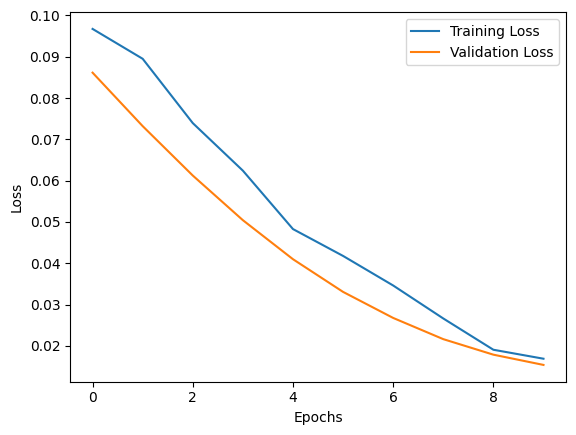

In [99]:
plt.plot(train_loss_all, label='Training Loss')
plt.plot(val_loss_all, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [109]:
model = LSTM(input_dim, hidden_dim, output_dim)
state_dict = torch.load(f'{path}/models/final_model.pt')
model.load_state_dict(state_dict)

<All keys matched successfully>

In [110]:
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loss, predictions, actual = evaluate(test_loader, model, nn.MSELoss())
print(f"Test Loss: {test_loss}")

100%|██████████| 2/2 [00:00<00:00, 17.44it/s]

Test Loss: 0.015519771259278059


# Testing Model on different E and M

In [92]:
parameters = [5, 10, 20, 30, 60]

In [111]:
results_df = pd.read_csv(f'{path}/preprocessed_dataset/eval_acc_testing.csv').iloc[:,1:5]

(5, 3)


100%|██████████| 2/2 [00:00<00:00, 19.49it/s]


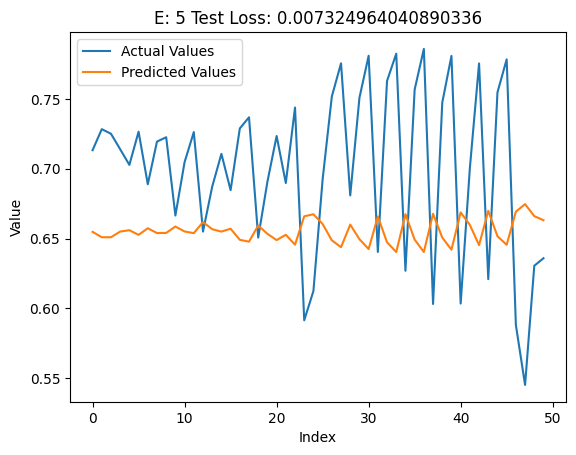

(10, 3)


100%|██████████| 2/2 [00:00<00:00, 18.86it/s]


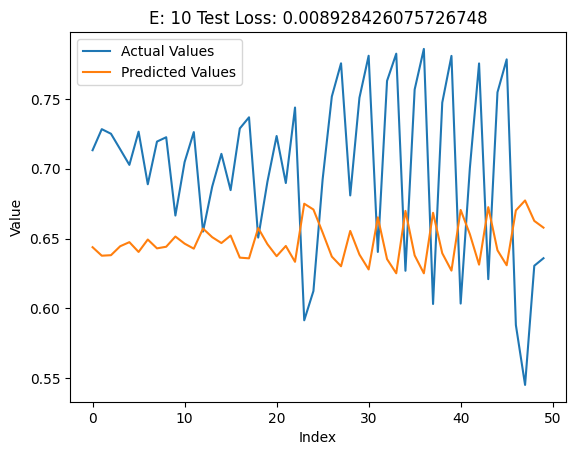

(20, 3)


100%|██████████| 2/2 [00:00<00:00, 19.10it/s]


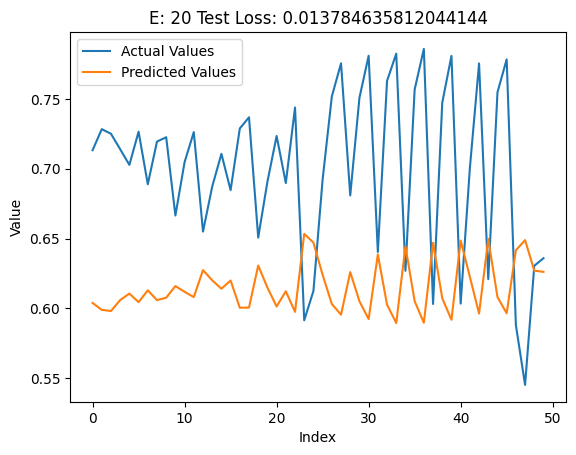

(30, 3)


100%|██████████| 2/2 [00:00<00:00, 19.17it/s]


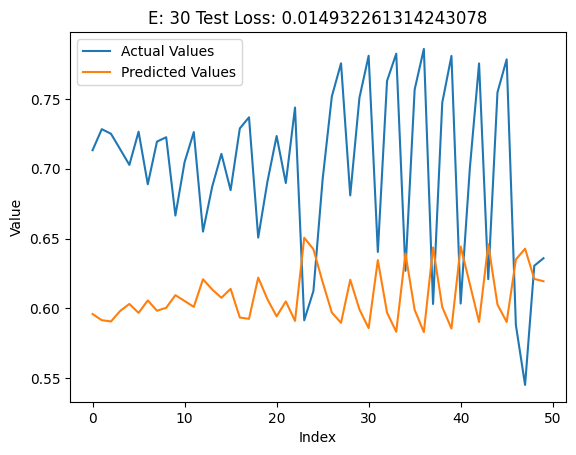

(60, 3)


100%|██████████| 2/2 [00:00<00:00, 15.86it/s]


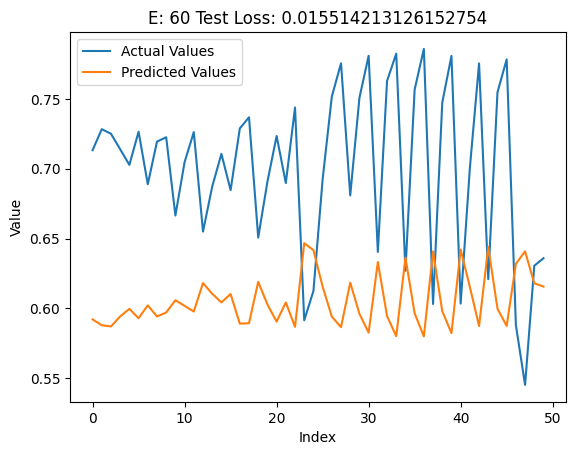

In [112]:
for i in parameters:
  test_dataset = EarlyStop(path=path, dataset_type='testing', E=i)
  print(test_dataset.data[0].shape)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
  test_loss, predictions, actual = evaluate(test_loader, model, nn.MSELoss())
  results_df[f"E:{i}"] = predictions
  plt.plot(actual, label='Actual Values')
  plt.plot(predictions, label='Predicted Values')
  plt.xlabel('Index')
  plt.ylabel('Value')
  plt.title(f'E: {i} Test Loss: {test_loss}')
  plt.legend()
  plt.show()

In [101]:
results_df.head()

,L1,H1,L2,H2,E:5,E:10,E:20,E:30,E:60
0,3.0,7.0,0.0,0.0,0.6548094,0.6437982,0.603863,0.5959174,0.5920575
1,3.0,11.0,0.0,0.0,0.65092456,0.6377084,0.59889245,0.5914885,0.5878794
2,3.0,15.0,0.0,0.0,0.65093136,0.6380754,0.5980708,0.59059423,0.5869881
3,5.0,7.0,0.0,0.0,0.65501606,0.6444819,0.6059196,0.5981295,0.59420824
4,5.0,11.0,0.0,0.0,0.6559783,0.6474209,0.61056256,0.60313666,0.5996157


In [97]:
results_df.to_csv(f'{path}/results/accuracies.csv')

In [ ]:
#If we want to use a different M, then we need to use the dataloader to load the appropriate data, and then perform the same steps of training the model as above.

# train_dataset = EarlyStop(path=path, dataset_type='training', E=M, M=M)
# val_dataset = EarlyStop(path=path, dataset_type='validation', E=M, M=M)
# test_dataset = EarlyStop(path=path, dataset_type='testing', E=E, M=M